In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.exceptions import ConvergenceWarning
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


## 03-04 data

In [3]:
# read NHANES data: Vitamin A, Vitamin E & Carotenoids 2005-2006
derm_2003 = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/derm_2003.XPT')
# Dermatology_questionaire
dermatology_questionaire = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/dermatology_questionaire.XPT')
# Alcohol
alcohol = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/alcohol.XPT')
# demo_2003
demo_2003 = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/demo_2003.XPT')
# body_measure
body_measure = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/body_measure.XPT')
# Vitimin_ace
vitamin_ace = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/vitamin_ace.XPT')
# use_of_supplements
use_of_supplements = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/use_of_supplements.XPT')
# smoking
smoking = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/smoking.XPT')
# vitimin_d
vitimin_d = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/vitimin_d.XPT')
# CRP
CRP = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/CRP.XPT')
# Supplement_count
supplement_count  = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/supplement_count.XPT')
# physical_activity
physical_activity = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/physical_activity.XPT')
# SMQMEC_C  smoke
SMQMEC_C = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/SMQMEC_C.XPT')
# immunization
immunization = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/immunization.XPT')

<ipython-input-3-42d5dd1f5c0a>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  derm_2003 = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/derm_2003.XPT')
<ipython-input-3-42d5dd1f5c0a>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  derm_2003 = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/derm_2003.XPT')


aggregate all data from 03-04

In [4]:

df_list_03 = [derm_2003,dermatology_questionaire,alcohol,demo_2003, body_measure,vitamin_ace, use_of_supplements, smoking, vitimin_d , CRP, supplement_count, physical_activity, SMQMEC_C, immunization]

merged_df_03 = df_list_03[0]

# Iterate through the list of DataFrames and join them based on 'common_column'
for df in df_list_03[1:]:
    merged_df_03 = pd.merge(merged_df_03, df, on='SEQN', how='left')

# Print the merged DataFrame
print('shape of merged_df', merged_df_03.shape)

# Check the number of null entries in each column
null_counts = merged_df_03.isnull().sum()



#only keep psoriasis related entries
df03 = merged_df_03[(merged_df_03['DEQ053']==1) | (merged_df_03['DEQ053']==2)]

# Display the resulting DataFrame
print('shape after drop', df03.shape)

#find target col
psoriasis_list = []
for index, row in df03.iterrows():
  if row['DEQ053'] == 1:
    psoriasis_list.append(1)
  else:
    psoriasis_list.append(0)
df03['psoriasis'] = psoriasis_list

df03['psoriasis'].value_counts()

shape of merged_df (10026, 364)
shape after drop (10011, 364)


<ipython-input-4-4990d1f10529>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df03['psoriasis'] = psoriasis_list


0    9710
1     301
Name: psoriasis, dtype: int64

## 05-06 data

In [5]:
bodymeasure_0506 = pd.read_sas('/content/drive/MyDrive/Capstone/data_0506/Bodymeasure_0506.xpt')
alcohol_0506 = pd.read_sas('/content/drive/MyDrive/Capstone/data_0506/alcohol_0506.xpt')
crp_0506 = pd.read_sas('/content/drive/MyDrive/Capstone/data_0506/CRP_0506.xpt')
demo_0506 = pd.read_sas('/content/drive/MyDrive/Capstone/data_0506/DEMO_0506.xpt')
derma_0506 = pd.read_sas('/content/drive/MyDrive/Capstone/data_0506/derma_0506.xpt')
immune_0506 = pd.read_sas('/content/drive/MyDrive/Capstone/data_0506/IMMUNE_0506.xpt')
smoking_0506 = pd.read_sas('/content/drive/MyDrive/Capstone/data_0506/Smoking_0506.xpt')
vitae_0506 = pd.read_sas('/content/drive/MyDrive/Capstone/data_0506/VITAE_0506.xpt')
vitd_0506 = pd.read_sas('/content/drive/MyDrive/Capstone/data_0506/VITD_0506.xpt')

In [6]:
df_list_05 =[bodymeasure_0506, alcohol_0506, crp_0506, demo_0506, derma_0506, immune_0506, smoking_0506, vitae_0506, vitd_0506]
merged_df_05 = df_list_05[0]

# Iterate through the list of DataFrames and join them based on 'common_column'
for df in df_list_05[1:]:
    merged_df_05 = pd.merge(merged_df_05, df, on='SEQN', how='left')

# Print the merged DataFrame
print('shape of merged_df', merged_df_05.shape)

#only keep psoriasis related entries
df05 = merged_df_05[(merged_df_05['DEQ053']==1) | (merged_df_05['DEQ053']==2)]


# Display the resulting DataFrame
print('shape after drop', df05.shape)

shape of merged_df (9950, 154)
shape after drop (3276, 154)


In [7]:
#find target col
psoriasis_list = []
for index, row in df05.iterrows():
  if row['DEQ053'] == 1:
    psoriasis_list.append(1)
  else:
    psoriasis_list.append(0)
df05['psoriasis'] = psoriasis_list

<ipython-input-7-3c14e7fdbcc8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df05['psoriasis'] = psoriasis_list


In [8]:
df05['psoriasis'].value_counts()

0    3193
1      83
Name: psoriasis, dtype: int64

## 13-14 data
no vitamin ace, crp


In [9]:
alcohol_1314 = pd.read_sas('/content/drive/MyDrive/Capstone/data_1314/Alcohol_1314.xpt')
bmi_1314 = pd.read_sas('/content/drive/MyDrive/Capstone/data_1314/BMI_1314.xpt')
demo_1314 = pd.read_sas('/content/drive/MyDrive/Capstone/data_1314/DEMO_1314.xpt')
# derm info in medical conditions questionnaire
derm_1314 = pd.read_sas('/content/drive/MyDrive/Capstone/data_1314/MCQ_H.xpt')
immune_1314 = pd.read_sas('/content/drive/MyDrive/Capstone/data_1314/Immune_1314.xpt')
smoking_1314 = pd.read_sas('/content/drive/MyDrive/Capstone/data_1314/Smoking_1314.xpt')
vitd_1314 = pd.read_sas('/content/drive/MyDrive/Capstone/data_1314/Vit_D_1314.xpt')

In [10]:
df_list_13 =[alcohol_1314, demo_1314, derm_1314, immune_1314, smoking_1314, vitd_1314]
merged_df_13 = df_list_13[0]

# Iterate through the list of DataFrames and join them based on 'common_column'
for df in df_list_13[1:]:
    merged_df_13 = pd.merge(merged_df_13, df, on='SEQN', how='left')

# Print the merged DataFrame
print('shape of merged_df', merged_df_13.shape)

# Check the number of null entries in each column
null_counts = merged_df_13.isnull().sum()


#only keep psoriasis related entries
df13 = merged_df_13[(merged_df_13['MCQ070']==1) | (merged_df_13['MCQ070']==2)]


# Display the resulting DataFrame
print('shape after drop', df13.shape)

shape of merged_df (5924, 196)
shape after drop (5918, 196)


In [11]:
#find target col
psoriasis_list = []
for index, row in df13.iterrows():
  if row['MCQ070'] == 1:
    psoriasis_list.append(1)
  else:
    psoriasis_list.append(0)
df13['psoriasis'] = psoriasis_list

<ipython-input-11-e92dadb96561>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df13['psoriasis'] = psoriasis_list


In [12]:
df13['psoriasis'].value_counts()

0    5769
1     149
Name: psoriasis, dtype: int64

## 11-12 data
no vitamin ace, crp

In [13]:
alcohol_1112 = pd.read_sas('/content/drive/MyDrive/Capstone/data_1112/Alcohol_1112.xpt')
bmi_1112 = pd.read_sas('/content/drive/MyDrive/Capstone/data_1112/BMI_1112.xpt')
demo_1112 = pd.read_sas('/content/drive/MyDrive/Capstone/data_1112/DEMO_1112.xpt')
# derm info in medical conditions questionnaire
derm_1112 = pd.read_sas('/content/drive/MyDrive/Capstone/data_1112/MCQ_G.xpt')
immune_1112 = pd.read_sas('/content/drive/MyDrive/Capstone/data_1112/immune_1112.xpt')
smoking_1112 = pd.read_sas('/content/drive/MyDrive/Capstone/data_1112/Smoking_1112.xpt')
vitd_1112 = pd.read_sas('/content/drive/MyDrive/Capstone/data_1112/VID_1112.xpt')

In [14]:
df_list_11 =[alcohol_1112, bmi_1112, demo_1112, derm_1112, immune_1112, smoking_1112, vitd_1112]
merged_df_11 = df_list_11[0]

# Iterate through the list of DataFrames and join them based on 'common_column'
for df in df_list_11[1:]:
    merged_df_11 = pd.merge(merged_df_11, df, on='SEQN', how='left')

# Print the merged DataFrame
print('shape of merged_df', merged_df_11.shape)

# Check the number of null entries in each column
null_counts = merged_df_11.isnull().sum()

#only keep psoriasis related entries
df11 = merged_df_11[(merged_df_11['MCQ070']==1) | (merged_df_11['MCQ070']==2)]

# Display the resulting DataFrame
print('shape after drop', df11.shape)

shape of merged_df (5615, 217)
shape after drop (5610, 217)


In [15]:
#find target col
psoriasis_list = []
for index, row in df11.iterrows():
  if row['MCQ070'] == 1:
    psoriasis_list.append(1)
  else:
    psoriasis_list.append(0)
df11['psoriasis'] = psoriasis_list

<ipython-input-15-2e50c9fcdf41>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df11['psoriasis'] = psoriasis_list


In [16]:
df11['psoriasis'].value_counts()

0    5458
1     152
Name: psoriasis, dtype: int64

## some more aggregations across the years

In [17]:
#find all columns that appear in all 4 dfs
# Extract the column names from each DataFrame
columns_df1 = set(df03.columns)
columns_df2 = set(df05.columns)
columns_df3 = set(df11.columns)
columns_df4 = set(df13.columns)

# Find the common columns among all DataFrames
common_columns = columns_df1.intersection(columns_df2, columns_df3, columns_df4)

# Convert the result to a list (if needed)
common_columns_list = list(common_columns)

# Print the common columns
print(common_columns_list)
print(len(common_columns_list))

['SMQ040', 'SMD030', 'IMQ020', 'SMD630', 'SMD055', 'MIALANG', 'WTINT2YR', 'RIDEXPRG', 'FIAPROXY', 'SMD100LN', 'SMQ050U', 'SMQ670', 'RIDEXMON', 'SMD100TR', 'SDDSRVYR', 'ALQ130', 'ALQ120Q', 'RIDAGEYR', 'FIALANG', 'SMD057', 'INDFMPIR', 'SMD100BR', 'SMD100CO', 'DMDHREDU', 'DMDHHSIZ', 'DMDHSEDU', 'SMD650', 'DMDMARTL', 'SIAINTRP', 'DMDYRSUS', 'ALQ101', 'SMQ020', 'SMQ050Q', 'SMD641', 'SMD100MN', 'SMD100NI', 'ALQ110', 'DMDHRGND', 'DMDEDUC2', 'SIAPROXY', 'SDMVPSU', 'SMD100FL', 'DMDHRAGE', 'RIDSTATR', 'SDMVSTRA', 'SMDUPCA', 'SIALANG', 'WTMEC2YR', 'SMD093', 'MIAPROXY', 'ALQ120U', 'RIAGENDR', 'RIDAGEMN', 'DMDHRMAR', 'RIDRETH1', 'DMDCITZN', 'MIAINTRP', 'SEQN', 'psoriasis', 'DMDEDUC3', 'FIAINTRP']
61


In [18]:
#update the common list by manually selecting some of the more interpreatble columns
common_columns_list =['psoriasis','INDFMPIR','RIDEXMON', 'SMQ670', 'SMD641', 'IMQ020', 'RIDAGEYR', 'SMD100FL', 'RIDEXPRG', 'SMD030', 'SMD100TR', 'DMDYRSUS', 'ALQ101', 'SMD100NI', 'SMD630', 'SMQ050Q', 'ALQ130', 'FIALANG', 'SMD100CO', 'SMD100MN', 'RIDRETH1','SMD093', 'DMDCITZN', 'DMDEDUC2', 'SMD100LN', 'SMD100BR', 'DMDHREDU', 'RIDAGEMN', 'WTMEC2YR', 'SMD055', 'SMQ020', 'SMQ040', 'SMD057', 'ALQ110', 'SMD650','RIAGENDR']
print(len(common_columns_list))

36


In [19]:
df03 = df03[common_columns_list]
df05 = df05[common_columns_list]
df11 = df11[common_columns_list]
df13 = df13[common_columns_list]
df = pd.concat([df03, df05, df11, df13], axis = 0)
print(df.shape)

(24815, 36)


In [20]:
df['psoriasis'].value_counts()

0    24130
1      685
Name: psoriasis, dtype: int64

In [21]:
#drop string columns

# Find and drop columns with string elements
string_columns = [col for col in df.columns if df[col].dtype == 'O']  # 'O' represents string dtype
df = df.drop(columns=string_columns)

# Display the DataFrame after dropping string columns
print(df.shape)

# Replace missing values with the mode for each column
df = df.fillna(df.mode().iloc[0])


(24815, 35)


# classification

In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# rename data frame
#df = df_subset_removena.drop(['DEQ053'], axis = 1)

#remove target feature
df_y = df['psoriasis']
df_x = df.drop(['psoriasis'], axis = 1)

#train test split
from sklearn.model_selection import train_test_split

# Split the data into a training set (70%) and a testing set (30%)
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)



(17370, 34) (7445, 34) (17370,) (7445,)


# takes 1 hr to run

Best Hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.5854936198791135
Confusion Matrix:
[[4217 3012]
 [  74  142]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.58      0.73      7229
           1       0.05      0.66      0.08       216

    accuracy                           0.59      7445
   macro avg       0.51      0.62      0.41      7445
weighted avg       0.96      0.59      0.71      7445



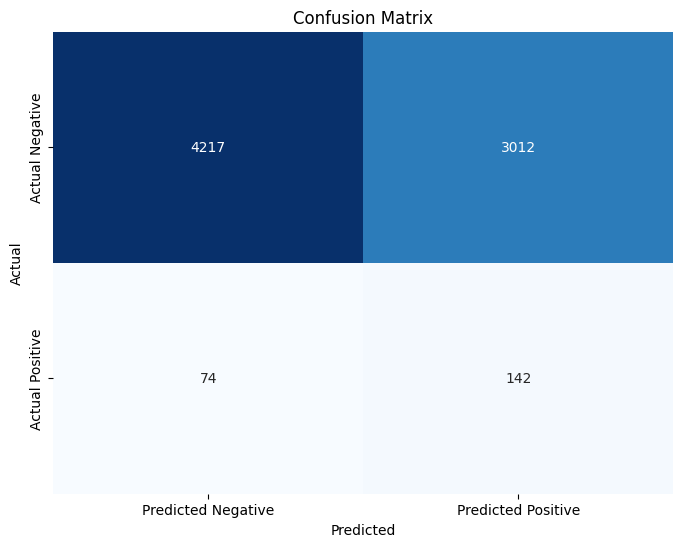

In [ ]:

# Perform oversampling on the training data (given we have split the data already)
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# smote = SMOTE(sampling_strategy='auto', random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)



warnings.filterwarnings("ignore", category=ConvergenceWarning)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],  
    'penalty': ['l1', 'l2'],          
    'solver': ['liblinear', 'lbfgs', 'saga', 'newton-cg'],  
}

logistic_regression = LogisticRegression()

grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, scoring='accuracy', cv=5)

grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(classification_report_str)



confusion = confusion_matrix(y_test, y_pred)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
pip install shap

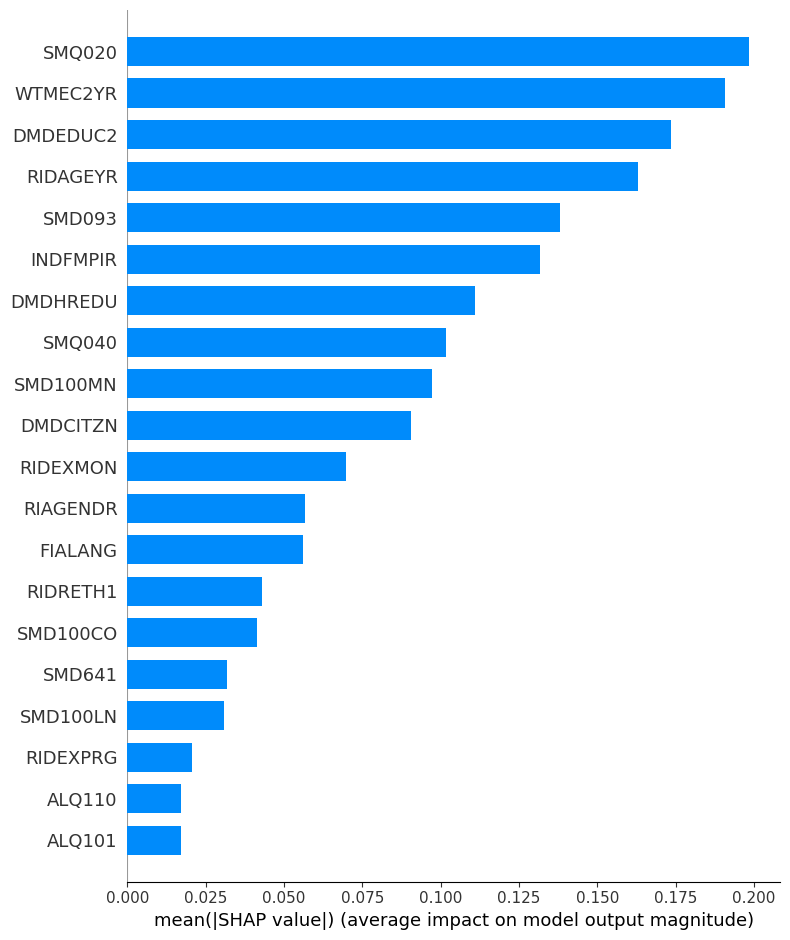

In [ ]:
import shap
explainer = shap.Explainer(best_model, X_train_resampled)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")


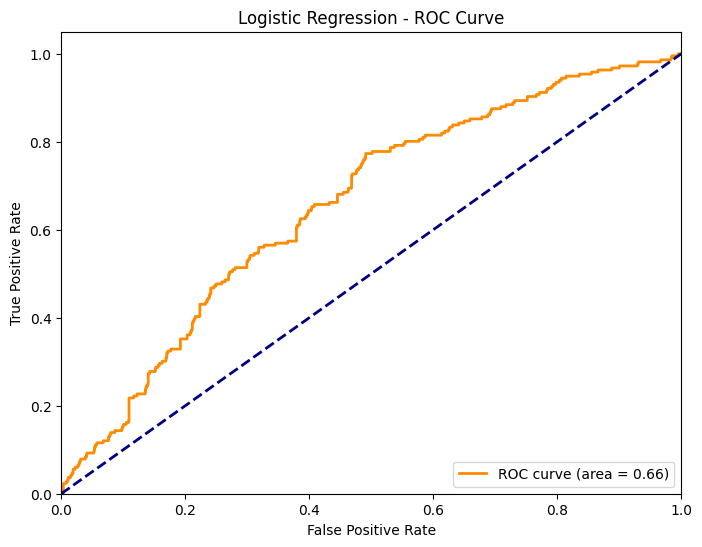

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
# Get the predicted probabilities for class 1
y_scores = best_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression - ROC Curve')
plt.legend(loc='lower right')
plt.show()

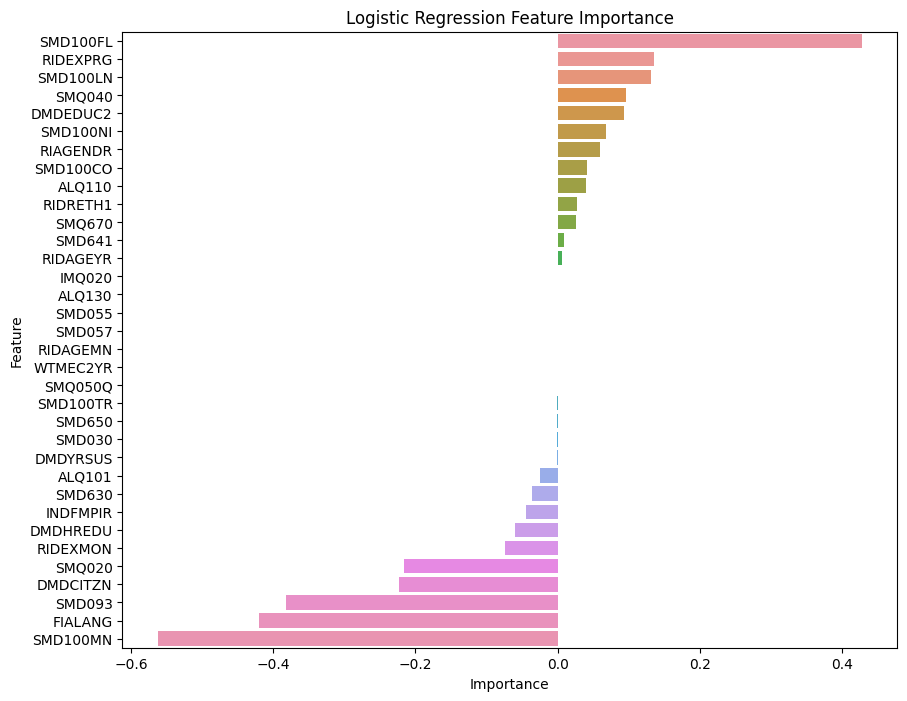

In [ ]:
import matplotlib.pyplot as plt

feature_importance = best_model.coef_[0]  

# Normalize the importance values
importance_normalized = feature_importance / np.linalg.norm(feature_importance)

feature_names = X_train.columns

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance_normalized})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Logistic Regression Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 200}
Accuracy: 0.9724647414372062


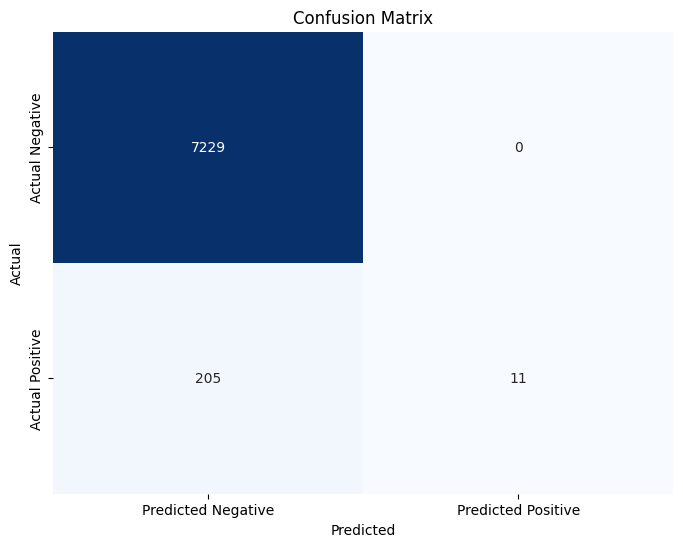

In [ ]:
#XGBoost (without over-sampling)

param_grid = {
    'n_estimators': [100, 200, 300],         
    'learning_rate': [0.01, 0.05, 0.1],    
    'max_depth': [4, 5, 6],                
    'min_child_weight': [1, 2, 3],         
}



xgb_classifier = xgb.XGBClassifier()


grid_search = GridSearchCV(estimator = xgb_classifier, param_grid=param_grid, scoring='precision', cv=5)


grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


best_model = grid_search.best_estimator_


y_pred = best_model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300}
Accuracy: 0.9621222296843519


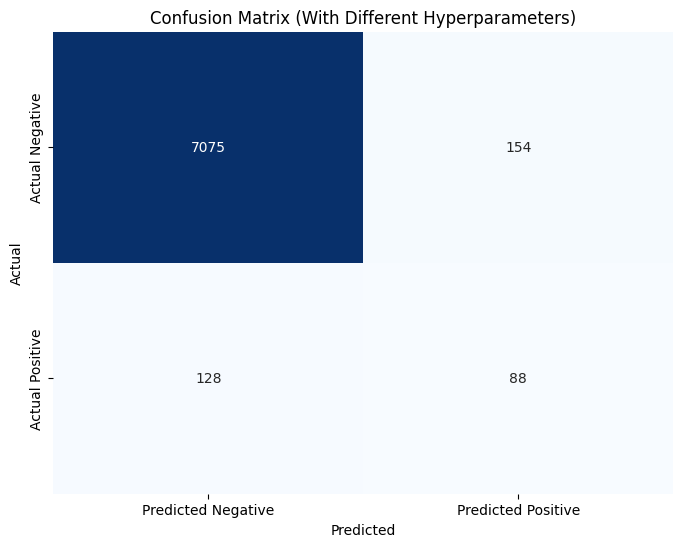

In [ ]:
#XGboost with oversampling

# Oversample the minority class in the training data
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=12)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)


param_grid = {
    'n_estimators': [100, 200, 300],         
    'learning_rate': [0.01, 0.05, 0.1],     
    'max_depth': [4, 5, 6],                
    'min_child_weight': [1, 2, 3],         
}

xgb_classifier = xgb.XGBClassifier()

grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, scoring='accuracy', cv=5)

grid_search.fit(X_train_resampled, y_train_resampled)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (With Different Hyperparameters)')
plt.show()


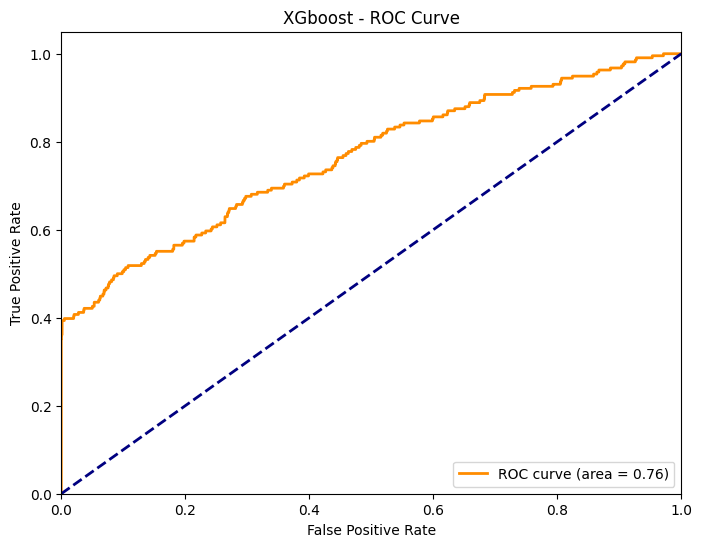

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_scores = best_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculate the AUC 
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGboost - ROC Curve')
plt.legend(loc='lower right')
plt.show()

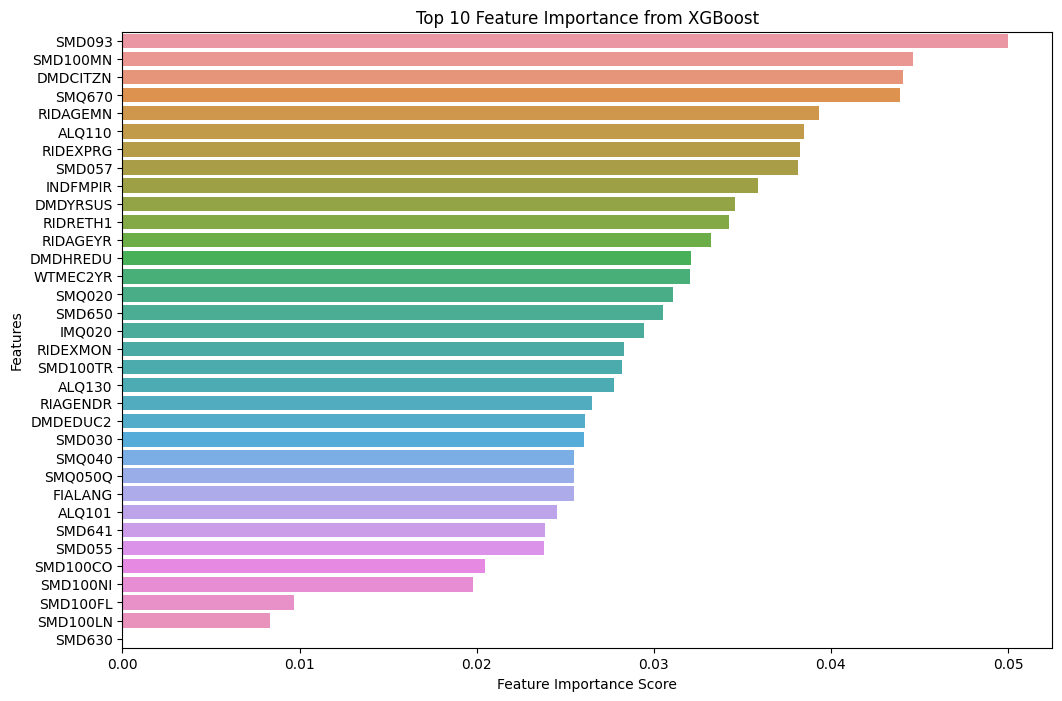

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

feature_importances = best_model.feature_importances_

feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns, 
    'Importance': feature_importances
})

# Sort the DataFrame to find the most important features
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Visualize the top 10 most important features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.title('Top 10 Feature Importance from XGBoost')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()


 99%|===================| 7405/7445 [01:28<00:00]       

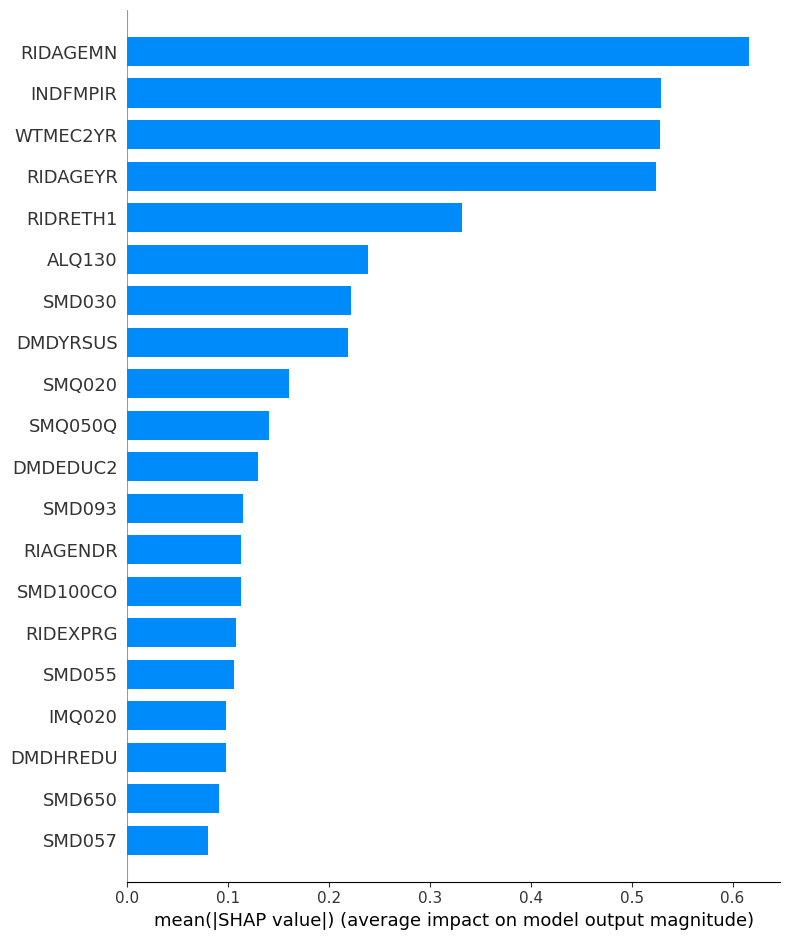

In [ ]:
import shap
# Create a SHAP explainer
explainer = shap.Explainer(best_model, X_train_resampled)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [25]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier

X = df.drop(['psoriasis'], axis=1)
y = df['psoriasis']

random_oversampler = RandomOverSampler(random_state=42)

X_resampled, y_resampled = random_oversampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [ 8, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 4]
}

grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_clf = RandomForestClassifier(random_state=42, **best_params)
best_clf.fit(X_train, y_train)

y_pred = best_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

matrix = confusion_matrix(y_pred, y_test)
print("Confusion Matrix:\n", matrix)

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.90748031496063
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      4787
           1       0.91      0.91      0.91      4865

    accuracy                           0.91      9652
   macro avg       0.91      0.91      0.91      9652
weighted avg       0.91      0.91      0.91      9652

Confusion Matrix:
 [[4350  456]
 [ 437 4409]]


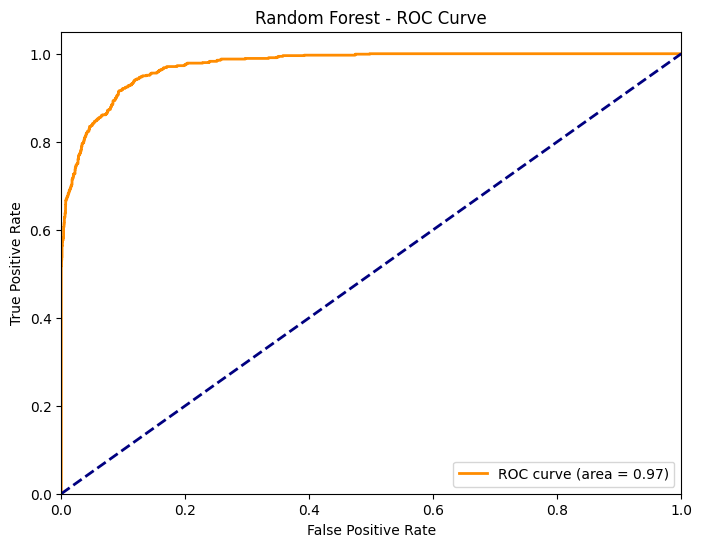

In [27]:
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

y_scores = best_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest - ROC Curve')
plt.legend(loc='lower right')
plt.show()

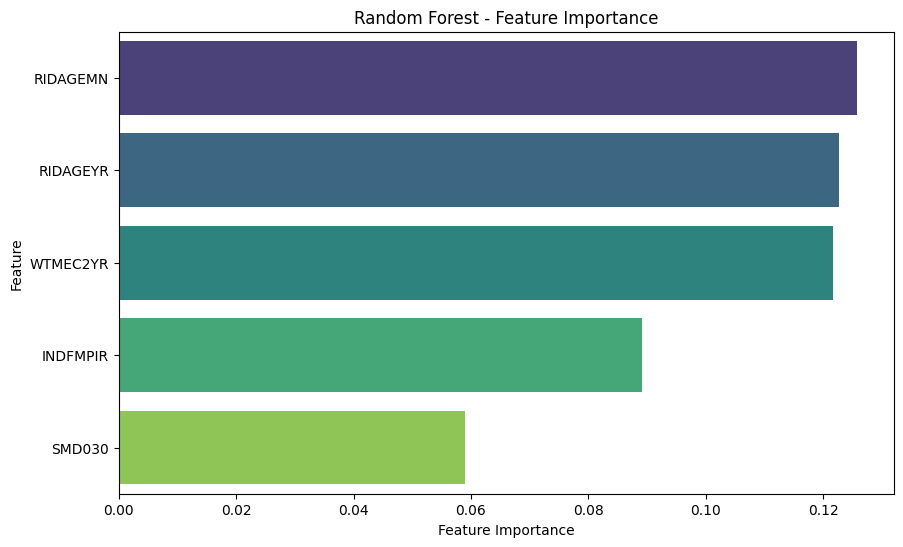

In [42]:
feature_importances = best_clf.feature_importances_

# Get the feature names
feature_names = X.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

sorted_feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).iloc[0,1:5,]

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=sorted_feature_importance_df, palette="viridis")
plt.xlabel('Feature Importance')
plt.title('Random Forest - Feature Importance')
plt.show()

In [41]:
sorted_feature_importance_df.iloc[0:5,]

,Feature,Importance
25,RIDAGEMN,0.125735
5,RIDAGEYR,0.122746
26,WTMEC2YR,0.121707
0,INDFMPIR,0.089096
8,SMD030,0.059014


In [31]:
! pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 5.7 MB/s eta 0:00:00


In [ ]:
from sklearn.svm import SVC
X = df.drop(['psoriasis'], axis=1)
y = df['psoriasis']

random_oversampler = RandomOverSampler(random_state=42)

# Fit and transform the data to oversample 
X_resampled, y_resampled = random_oversampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

clf = SVC()

param_grid = {
    'kernel': ['linear', 'poly', 'sigmoid']
}

# Create a Grid Search with cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=5)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_clf = SVC(**best_params)

best_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

matrix = confusion_matrix(y_pred, y_test)
print("Confusion Matrix:\n", matrix)




In [ ]:
y_scores = best_clf.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Create the ROC curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM - ROC Curve')
plt.legend(loc='lower right')

plt.show()



NameError: ignored

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

if best_clf.kernel == 'linear':
    feature_weights = best_clf.coef_.ravel()
    feature_names = X.columns 

    # Calculate the absolute values of feature weights
    absolute_feature_weights = abs(feature_weights)

    # Calculate the sum of absolute weights to use for normalization
    total_absolute_weight = sum(absolute_feature_weights)

    relative_importance = (absolute_feature_weights / total_absolute_weight) * 100

    feature_importance = pd.DataFrame({'Feature': feature_names, 'Relative Importance (%)': relative_importance})

    # Sort the features by relative importance
    sorted_feature_importance = feature_importance.sort_values(by='Relative Importance (%)', ascending=False)

    # Create a bar chart to visualize feature importance as percentages using Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Relative Importance (%)', y='Feature', data=sorted_feature_importance, palette="viridis")
    plt.xlabel('Relative Feature Importance (%)')
    plt.title('Feature Importance for SVM with Linear Kernel (Percentage)')
    plt.show()

else:
    print("Feature importances as percentages are only available for SVM with a linear kernel.")


In [ ]:
print('hi')

In [ ]:
import shap
# Create a SHAP explainer
explainer = shap.Explainer(best_clf, X_train_resampled)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")